In [1]:
from osgeo import gdal 
import xarray as xr 
import rasterio
import rasterio.plot
from PIL import Image, ImageOps
import subprocess

In [14]:
ds = xr.open_dataset('sample/indonesia-20230901-20230907.nc')
# ds = xr.open_dataset('http://182.16.248.173:8080/dods/INA-NWP/2023102800/2023102800-d01-asim')

In [21]:
t_tiff = 'temp.tiff'
rgb_tiff = "rgb.tiff"
t = ds['t2m']
_t = t[0].rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
# t = ds['tc']
# _t = t[0][0].rio.set_spatial_dims(x_dim='lon', y_dim='lat')
_t.rio.crs
_t.rio.write_crs("epsg:4326", inplace=True)
_t.rio.to_raster(t_tiff)

<open DatasetReader name='temp.tiff' mode='r'>

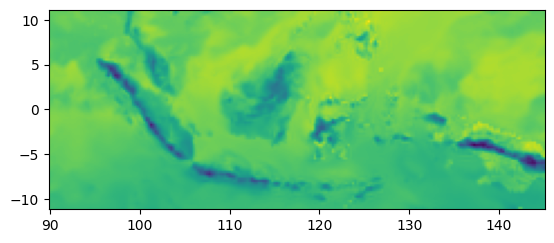

<Axes: >

In [22]:
tiff = rasterio.open(t_tiff)
display(tiff)
rasterio.plot.show(tiff)

In [23]:
subprocess.run([r"gdaldem.exe", "color-relief", t_tiff, "color.txt", rgb_tiff])

CompletedProcess(args=['gdaldem.exe', 'color-relief', 'temp.tiff', 'color.txt', 'rgb.tiff'], returncode=0)

<open DatasetReader name='rgb.tiff' mode='r'>

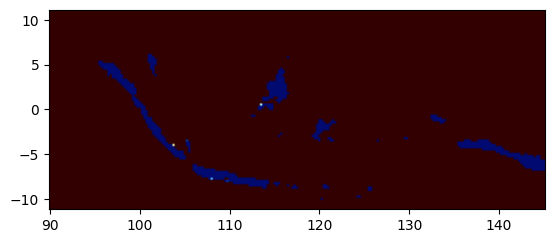

<Axes: >

In [24]:
tiff = rasterio.open(rgb_tiff)
display(tiff)
rasterio.plot.show(tiff)

In [13]:
subprocess.run(["python", "C:/Users/falbas/miniconda3/Scripts/gdal2tiles.py", "--zoom=5-7", rgb_tiff, "tiles/baselayer1"])

CompletedProcess(args=['python', 'C:/Users/falbas/miniconda3/Scripts/gdal2tiles.py', '--zoom=5-7', 'rgb.tiff', 'tiles/baselayer1'], returncode=0)

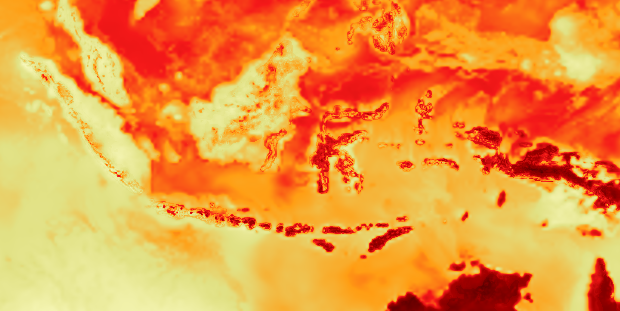

In [7]:
# tiff = rasterio.open(t_tiff)
# display(tiff)
# rasterio.plot.show(tiff)

t_img = ImageOps.flip(Image.open(rgb_tiff))
t_img = t_img.save(rgb_tiff)
t_img = Image.open(rgb_tiff)
display(t_img)
t_img.close()

<open DatasetReader name='temp.tiff' mode='r'>

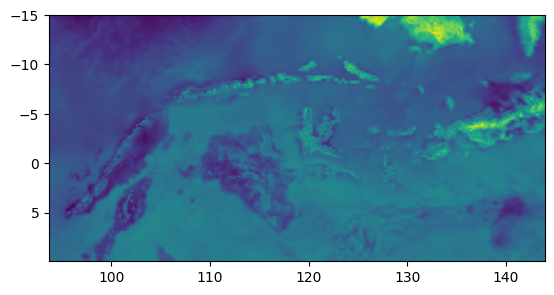

<Axes: >

In [46]:
tiff = rasterio.open(t_tiff)
display(tiff)
rasterio.plot.show(tiff)